Use U-Net for region proposals. Use conv classifier on top of that. 

1. region proposals
2. slide window approach on proposed regions, using different window sizes, differenced by 10 pixels
3. test on different images from video
4. video pipeline, smoothing over 10 frames

In [1]:
from unet import *

Using TensorFlow backend.


In [2]:
import cv2
import numpy as np
import time; import os; import pickle; import glob
import matplotlib.image as mpimg; import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
model = get_unet()
model.load_weights('./output/model_11epochs.hdf5') # dice_coeff = 0.4398

In [4]:
h, w, c = 1200, 1920, 3

In [34]:
def resize_image_for_unet(img):
    return cv2.resize(img, (w,h))

In [82]:
def select_random_frames(path='./project_video_frames/*.jpeg', n=10):
    frames = glob.glob(path)
    indices = np.random.choice(np.arange(len(frames)), n, replace=False)
    img_arr = np.zeros((n,h,w,3))
    for i,v in enumerate(indices):
        img_arr[i,] = resize_image_for_unet(mpimg.imread(frames[i]))
    return img_arr

In [91]:
img_arr = select_random_frames('./test_images/*.jpg',n=6)

In [92]:
pred_arr = model.predict(img_arr)

In [93]:
def plot_img_mask(img_arr, pred_arr):
    n = img_arr.shape[0]
    
    fig = plt.figure()
    fig.set_figwidth(8); fig.set_figheight(n*3)
    
    for i in np.arange(n): 
        img = np.array(img_arr[i,], dtype=np.uint8)
        
        ax = fig.add_subplot(n, 2, i*2+1)
        ax = plt.imshow(img)
        
        pred = np.array(pred_arr[i,]*255, dtype=np.uint8)
        pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
        pred[:,:,[1,2]] = 0*pred[:,:,1:2]
        pred = cv2.addWeighted(pred, 0.5, img, 1, 0)
        
        ax = fig.add_subplot(n, 2, i*2+2)
        ax = plt.imshow(pred)
        
    return ax

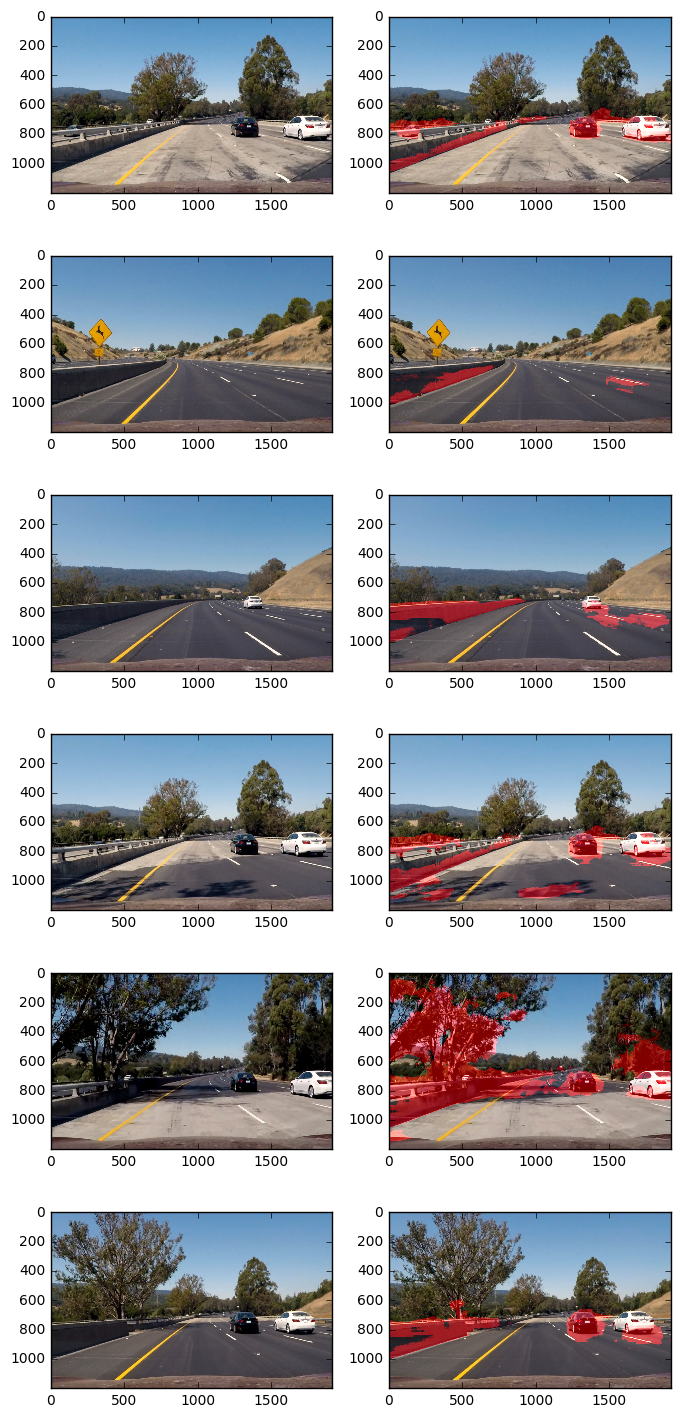

In [94]:
plot_img_mask(img_arr, pred_arr)

In [95]:
img_arr = select_random_frames('./test_images/*.jpg',n=1)
start = time.time()
pred_arr = model.predict(img_arr)
end = time.time()
print("Prediction time for one image: {}".format(end-start))

Prediction time for one image: 1.5196850299835205


In [ ]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img